#### 1. Motivation<br>
Covid-19 started in November 2019 and started to spread across the world killing 3.74 million people. To curb the spread were to wear masks and maintain 6 feet distance. Although vaccines are available now and the cases have come down in some few countries, many countries are still struggling. In order to aid in stopping the spread and identify individuals not following the safety policies, we aim to build an Object Detection and Convolution Neural Network based face mask and social distance detection system. The dataset to be used contains numerous images of instances where people are with and without mask and the model aims to identify people violating safety policies and flag the images with violation concerns. <br>


**Objective:**

Identiying if a person is wearing facemask or not and violating any social distance norms.

In [35]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from trulens.nn.models import get_model_wrapper
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients

import PIL

### Getting the directories, Path and Data

In [2]:
path = "./Face Mask Dataset/"

In [3]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./Face Mask Dataset/Test/WithoutMask/2734.png,WithoutMask,Test
1,./Face Mask Dataset/Test/WithoutMask/4345.png,WithoutMask,Test
2,./Face Mask Dataset/Test/WithoutMask/4423.png,WithoutMask,Test
3,./Face Mask Dataset/Test/WithoutMask/2052.png,WithoutMask,Test
4,./Face Mask Dataset/Test/WithoutMask/3364.png,WithoutMask,Test


### Face Detection using HAAR Cascade Algorithm

##### Drawbacks:

We can observe that Default face detection Haar Cascading that we choose doesnt do a good job in identifying the faces. (Will replace this with other algorithms)

### Visualisations

With Mask: 5909
Without Mask: 5883


<AxesSubplot:xlabel='mask_status', ylabel='count'>

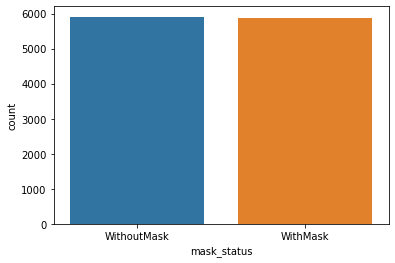

In [5]:
## Checking for total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

## Plotting the numbers
sns.countplot(x = dataset["mask_status"])

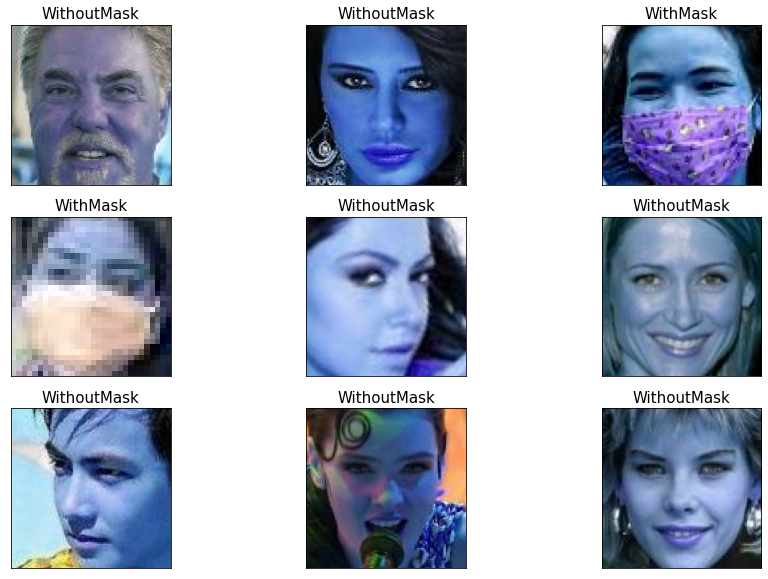

In [6]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

                                          image_path  mask_status  where
992   ./Face Mask Dataset/Train/WithoutMask/3975.png  WithoutMask  Train
993    ./Face Mask Dataset/Train/WithoutMask/348.png  WithoutMask  Train
994   ./Face Mask Dataset/Train/WithoutMask/1804.png  WithoutMask  Train
995   ./Face Mask Dataset/Train/WithoutMask/4968.png  WithoutMask  Train
996   ./Face Mask Dataset/Train/WithoutMask/1810.png  WithoutMask  Train
997   ./Face Mask Dataset/Train/WithoutMask/3961.png  WithoutMask  Train
998   ./Face Mask Dataset/Train/WithoutMask/1186.png  WithoutMask  Train
999    ./Face Mask Dataset/Train/WithoutMask/412.png  WithoutMask  Train
1000  ./Face Mask Dataset/Train/WithoutMask/3949.png  WithoutMask  Train
1001  ./Face Mask Dataset/Train/WithoutMask/3791.png  WithoutMask  Train

 After Shuffling 

                                             image_path  mask_status  where
2539      ./Face Mask Dataset/Train/WithoutMask/101.png  WithoutMask  Train
9234  ./Face Mask Dataset

### Visualising the distribution of train test and validation set

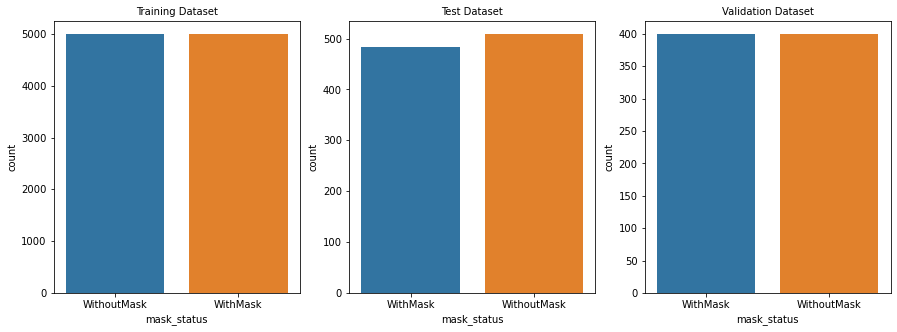

In [8]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [9]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,./Face Mask Dataset/Train/WithoutMask/101.png,WithoutMask,Train
1,./Face Mask Dataset/Train/WithMask/Augmented_8...,WithMask,Train
2,./Face Mask Dataset/Train/WithMask/Augmented_5...,WithMask,Train
3,./Face Mask Dataset/Train/WithoutMask/4900.png,WithoutMask,Train
4,./Face Mask Dataset/Train/WithoutMask/3337.png,WithoutMask,Train


In [10]:
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [11]:
data = np.array(data)

/var/folders/4k/2q_gdnx53plgtrz7y4n8qyd80000gn/T/ipykernel_45382/4012140830.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


(2,)


In [12]:
data[0][0].shape

(150, 150)

In [13]:
## Shuffling the data to make sure everything is not in order
np.random.shuffle(data)

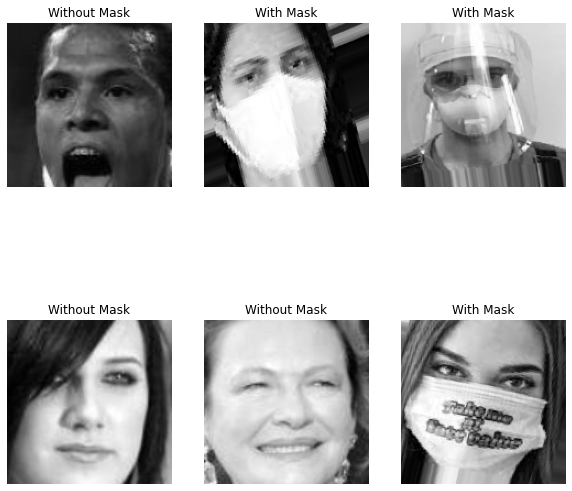

In [14]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

In [44]:
# datagen = ImageDataGenerator(rescale = 1./255)

# train_generator=datagen.flow_from_dataframe(
# dataframe=train_df,
# directory="../input",
# x_col="image_path",
# y_col="mask_status",
# batch_size=80,
# seed=42,
# shuffle=False,
# class_mode="binary",
# target_size=(150,150))

### Preparing data to be loaded into the Model

In [15]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

In [16]:
### Normalizing the data
X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Building the model

In [17]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
# model.summary()

2022-04-09 13:24:14.654934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
# X_train = X_train.reshape(-1, 32, 150, 150)
## Reshaping training set to match Conc2D
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 311s 1s/step - loss: 0.2390 - accuracy: 0.8913
Epoch 2/5
250/250 [==============================] - 323s 1s/step - loss: 0.0805 - accuracy: 0.9726
Epoch 3/5
250/250 [==============================] - 377s 2s/step - loss: 0.0558 - accuracy: 0.9801
Epoch 4/5
250/250 [==============================] - 343s 1s/step - loss: 0.0617 - accuracy: 0.9785
Epoch 5/5
250/250 [==============================] - 327s 1s/step - loss: 0.0473 - accuracy: 0.9831


In [20]:
model.summary()
# model.save('classification_09831')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 148, 148, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (32, 146, 146, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 48, 48, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 46, 46, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (32, 44, 44, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 14, 14, 64)         0         
 2D)                                                    

In [113]:
model.evaluate(X_val, y_val)

/Users/guanzhaoli/opt/anaconda3/envs/TF2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 [==============================] - 29s 465ms/step - loss: 0.0510 - accuracy: 0.9810


[0.05098849907517433, 0.9810000061988831]

In [114]:
print(X_val.shape)

(2000, 150, 150, 1)


In [115]:
prediction = model.predict(X_val)

In [116]:
print(prediction)

[[0.99991536]
 [1.        ]
 [0.9998921 ]
 ...
 [1.        ]
 [0.00499111]
 [0.99999845]]


In [117]:
model_wrapped = get_model_wrapper(model)

INFO: Detected tensorflow backend for <class 'keras.engine.sequential.Sequential'>.
INFO: Using backend Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


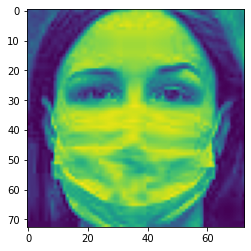

In [118]:
with PIL.Image.open('./46.png') as img:
    img = PIL.ImageOps.grayscale(img)
    plt.imshow(img)
    
    x_pp = np.array(img.resize((150,150), PIL.Image.ANTIALIAS))[np.newaxis]
    

prediction = model.predict(x_pp)

In [119]:
x_pp

array([[[ 53,  55,  60, ..., 134, 140, 145],
        [ 56,  57,  60, ..., 130, 138, 143],
        [ 61,  60,  59, ..., 123, 133, 140],
        ...,
        [  6,   7,   7, ...,   4,   4,   4],
        [  6,   7,   7, ...,   6,   8,   9],
        [  8,   7,   7, ...,   8,  10,  12]]], dtype=uint8)

In [120]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [121]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

In [122]:
baseline = tf.zeros(shape=(150,150,1))

In [123]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [124]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [125]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=150, target_width=150)
  return image

img_name_tensor = read_image('./46.png')
print(img_name_tensor.shape)

(150, 150, 1)


In [126]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensor,
    alphas=alphas)

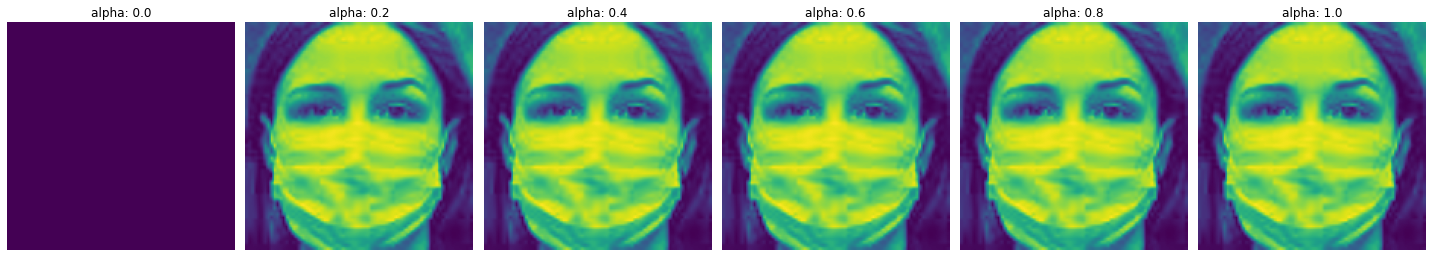

In [127]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [164]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
#     probs = tf.nn.softmax(logits, axis=-1)
    
  return tape.gradient(logits, images)

In [165]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=1)

In [166]:
print(path_gradients.shape)

(51, 150, 150, 1)


In [167]:
pred = model(interpolated_images)

pred_proba = tf.nn.softmax(pred, axis=-1)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

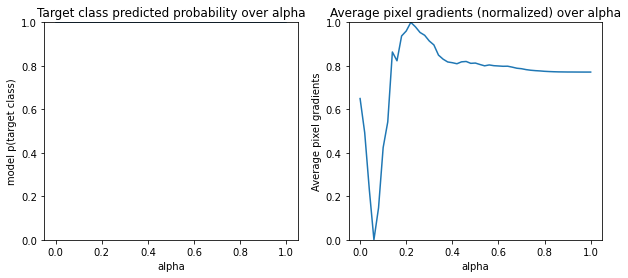

In [168]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [169]:
ig = integral_approximation(gradients=path_gradients)

In [170]:
print(ig.shape)

(150, 150, 1)


In [171]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [172]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [173]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensor,
                                       target_class_idx=0,
                                       m_steps=240)

In [174]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

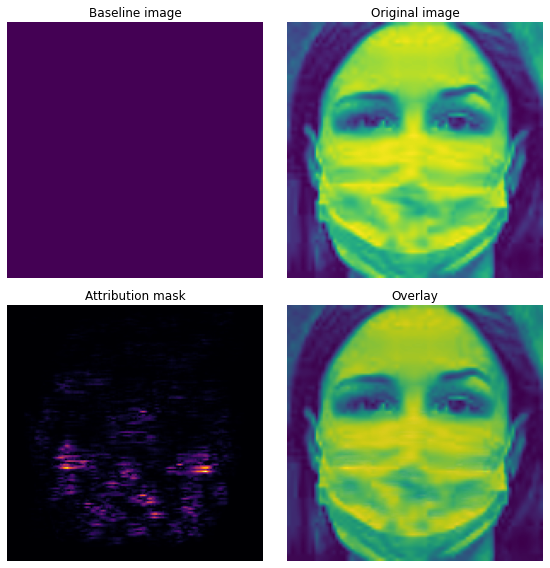

In [175]:
_ = plot_img_attributions(image=img_name_tensor,
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.9)